Dices detection
=========================================
***Komunikacja człowiek-komputer 2021***   

**Authors**: Katarzyna Badio, Julia Chabora  

### Importing libraries

In [1]:
import numpy as np
import os
import cv2
from matplotlib import pylab as plt 
from ipywidgets import interact
import pandas as pd
import csv

### Preprocessing images

In [2]:
directory = r'./dices/100_dices'
#directory = r'./dices/100_dices_additional_dataset'
#directory = r'./dices/10_dices'

dices = []
dices_paths = []
original_dices = []
i = 0
for dice_image in os.scandir(directory):
    dices.append(dice_image.path)
    dices_paths.append(dice_image.path)
    #plt.figure(figsize=(250, 250))

    img = cv2.imread(dices[i])
    original_dices.append(img)
    
    # 0. Change colorscale to gray
    imggrayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #new_image = cv2.convertScaleAbs(imggrayscale, alpha=0.6, beta=100)
    
    # 1. Blurring dices to remove sharp edges
    blur = cv2.blur(imggrayscale, (3, 3), 0)
    
    # 2. Threshold
    _, thresholded = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    #canny = cv2.Canny(new_image, 120, 200)
    
    # 3. Erosion
    kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(thresholded,kernel,iterations = 2)
    
    # 4. Dilation
    kernel1 = np.ones((3,3),np.uint8)
    dices[i] = cv2.dilate(erosion,kernel1,iterations = 1)
    
    
    # ax = plt.subplot(100, 1, i+1)
    # ax.imshow(thresholded, cmap='gray')
    # ax.set_xticks([]), ax.set_yticks([])
    # ax.axis([0, img.shape[1], img.shape[0], 0])
    
    i += 1 


## Results

/tmp/ipykernel_29252/3399077099.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(250, 250))


Average area of dices dots:  81.31931317543793
Average area of dices:  1888.6862380952382


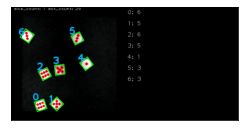

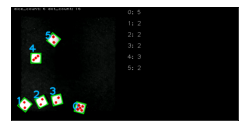

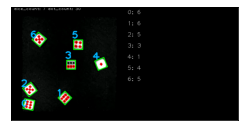

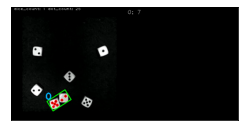

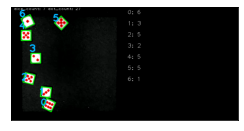

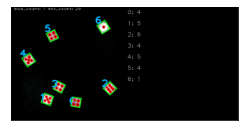

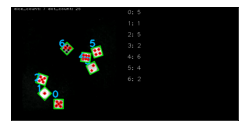

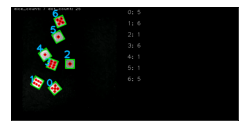

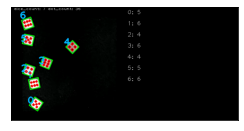

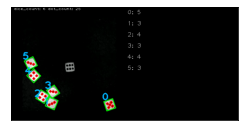

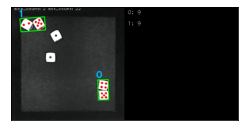

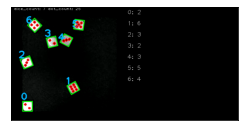

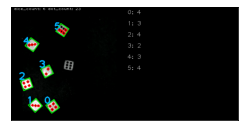

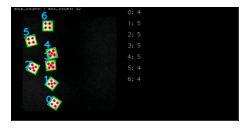

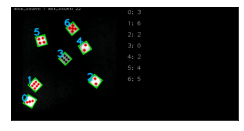

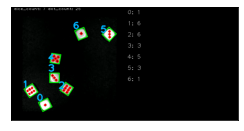

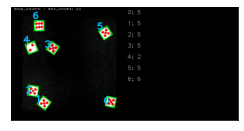

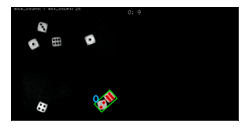

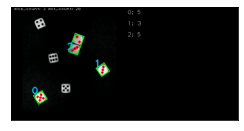

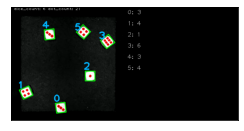

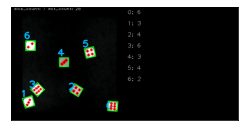

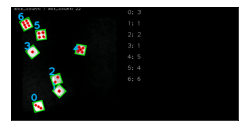

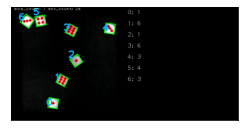

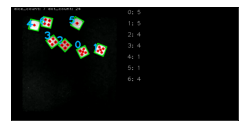

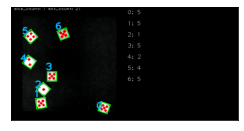

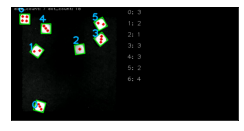

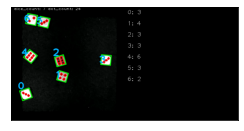

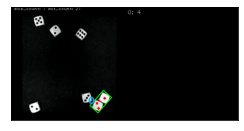

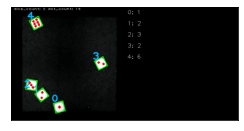

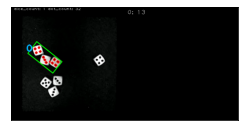

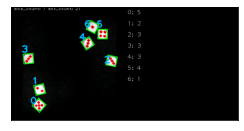

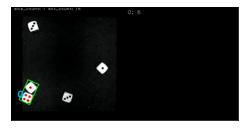

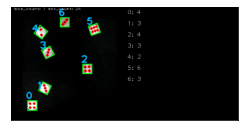

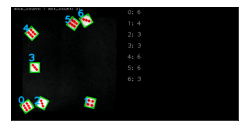

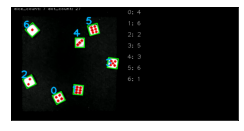

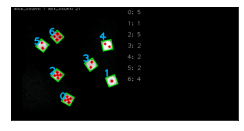

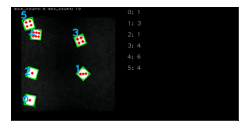

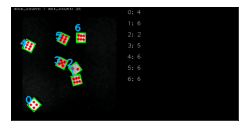

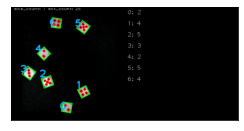

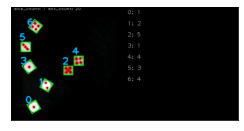

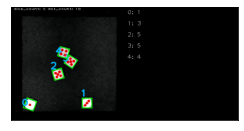

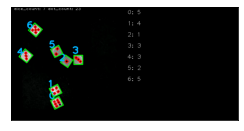

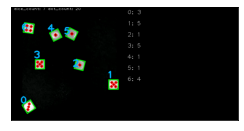

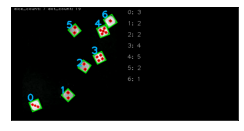

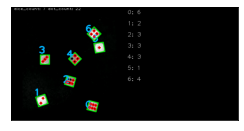

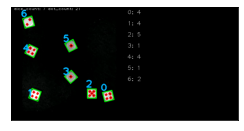

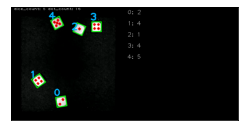

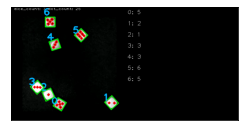

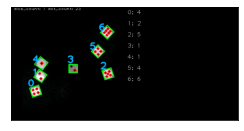

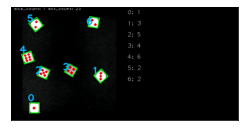

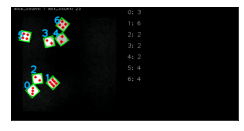

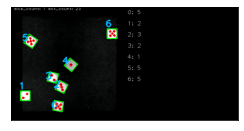

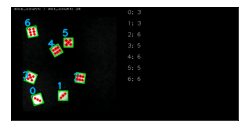

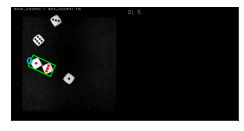

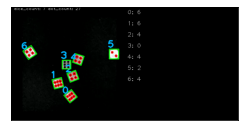

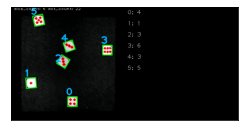

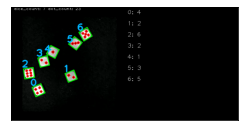

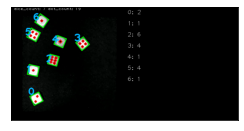

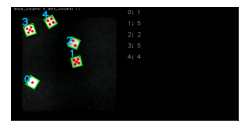

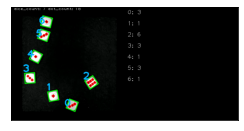

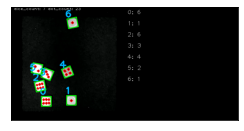

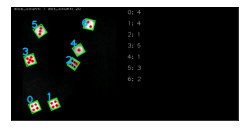

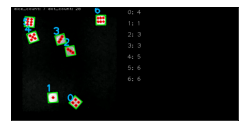

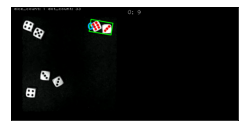

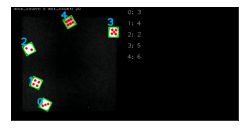

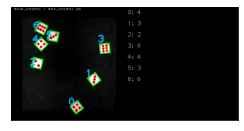

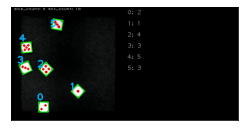

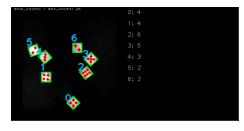

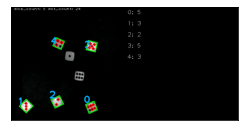

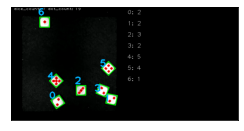

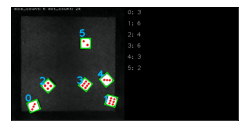

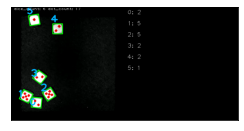

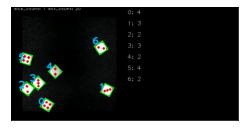

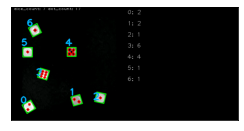

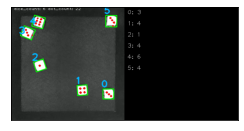

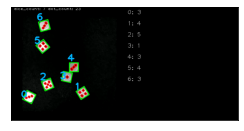

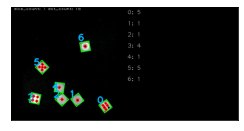

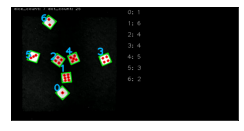

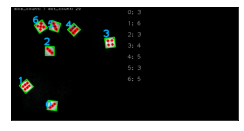

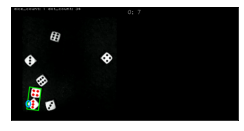

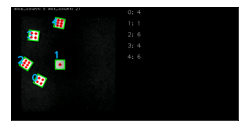

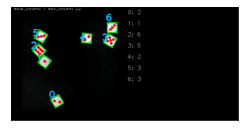

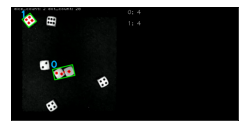

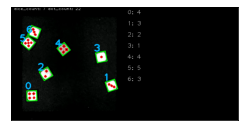

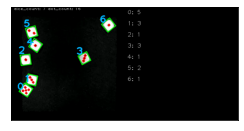

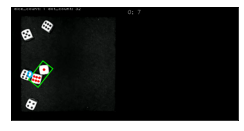

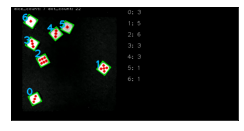

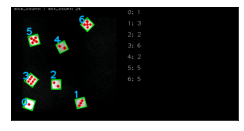

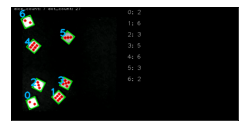

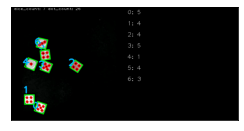

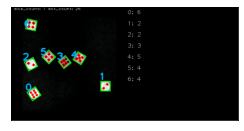

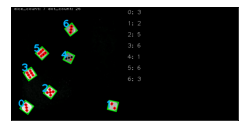

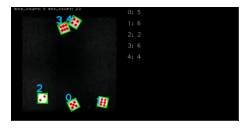

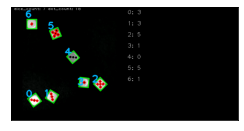

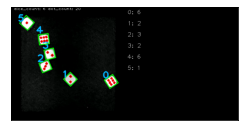

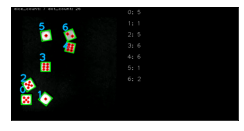

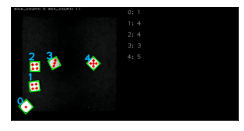

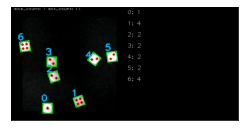

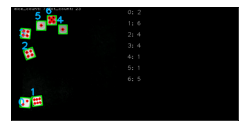

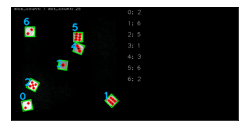

In [3]:
row_list = []

suma_oczko_all_iterations = 0
suma_dice_all_iterations = 0
iteration = 0
i = 0
dice_areas = []
for dice_image, original, dice_path in zip(dices, original_dices, dices_paths):
    
    
    plt.figure(figsize=(250, 250))
   
    # 5. Finding contours of an image.
    contours, _ = cv2.findContours(dice_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 6. Calculating areas of found contours.
    areas = []
    boxes_with_points = [] 
    for contour in contours:
        _, _, width, height = cv2.boundingRect(contour)
        #print("w: ", width, " h: ", height)
        # Checking propotions of bounding box - must fit square
        #if  height* 0.9 < width < height * 1.1 or width * 0.9 < height < width * 1.1: 
        areas.append(width*height)
        
    dice_areas.append(areas)
    
    
    # 6.1 Using average as a middle point to differ between dots and dices boxes
    labels = []
    dice_dict = {}
    dice_count = 0
    middle = (max(areas) - min(areas)) / 2
    avg_dot_area = 81
    avg_dice_area = 1888
        
    suma_area_oczko = 0
    suma_area_dice = 0
    oczko_count = 0
    for area in areas:
        
        if  area < middle: 
            labels.append('oczko')
            
            suma_area_oczko += area
            oczko_count += 1
        
        else:
            labels.append('kostka')
            dice_dict[dice_count] = 0
            
            suma_area_dice += area
            dice_count += 1
        
    
    if oczko_count > 0 and dice_count > 0:
        suma_oczko_all_iterations += suma_area_oczko / oczko_count
        suma_dice_all_iterations += suma_area_dice / dice_count

    dice_count = 0
    dot_count = 0
    for contour, label in zip(contours, labels):
        
         # 7. Drawing contours according to labels.
        rectangle = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rectangle)
        box = np.int0(box)
        
        if label == 'kostka':
            cv2.drawContours(original, [box], -1, (0, 255, 0), 2,  cv2.LINE_AA)
            # 7.1 Displaying id of dice in a picture
            cv2.putText(original, str(dice_count), (box[0][0] - 7, box[0][1] - 5), cv2.FONT_HERSHEY_PLAIN, 2.5, (0, 180, 255), 3)
            dice_count += 1
            
            
        elif label == 'oczko':
            
            
            # 7.2 If dice for a dot is found -> ++
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            k = 0
            c = 0
            for label in labels:
                if label == 'kostka':
                    
                    result = cv2.pointPolygonTest(contours[c], (cX, cY), False)
                    if result > 0:
                        dice_dict[k] += 1
                        cv2.drawContours(original, [box], -1, (255, 0, 0), 2,  cv2.LINE_AA)
                    
                    k += 1
                c += 1
                    
            dot_count += 1
        
                        
    # 8. Put dice count and dot count text on a black image
    cv2.putText(original, "dice_count: "+ str(dice_count) + " dot_count: "+ str(dot_count), (10,15), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    
    height, width, channels = original.shape
    # 9. Add blank black image and concatenate with original picture
    blank_image = np.zeros((height, width, channels), np.uint8)
    
    r = 30
    for key, value in dice_dict.items():
        cv2.putText(blank_image, str(key) + ": " + str(value), (10, r), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255))
        r += 40
        
    dices_walls_dict = {
        1: 0,
        2: 0,
        3: 0, 
        4: 0, 
        5: 0, 
        6: 0
    }
    # 10. Counting and saving T/F to an csv file, comparing dot_count with actual value
    for value in dice_dict.values():
        if 1 <= value <= 6:
            dices_walls_dict[value] += 1
    
    row = [
            dice_path,
            dice_count,
            dices_walls_dict[1],
            dices_walls_dict[2],
            dices_walls_dict[3],
            dices_walls_dict[4],
            dices_walls_dict[5],
            dices_walls_dict[6],
            dot_count]
    
    row_list.append(row)
        
    concatenated = cv2.hconcat([original, blank_image])
    ax = plt.subplot(100, 1, i+1)
    ax.imshow(concatenated)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, concatenated.shape[1], concatenated.shape[0], 0])
    
    iteration += 1
    
    
avg_area_oczko_all_iterations = suma_oczko_all_iterations / iteration 
avg_area_dice_all_iterations = suma_dice_all_iterations / iteration 
print("Average area of dices dots: ", avg_area_oczko_all_iterations)
print("Average area of dices: ", avg_area_dice_all_iterations)
    

## Saving results to an csv file

In [4]:
with open('dices/results/results_100_dices.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'dice_count', '1_count', '2_count', '3_count', '4_count', '5_count', '6_count', 'dot_sum'])
    writer.writerows(row_list)

## Working with csv files 

In [8]:
# Add a new column and sort file in ascending order by its values
df = pd.read_csv("dices/results/results_100_dices.csv")
df["splitted"] = df["filename"].agg([lambda f: int(f.split('/')[3].split('.')[0])])
sorted_df = df.sort_values(by=["splitted"], ascending=True)

sorted_df.to_csv('./dices/results/sorted_100_dices.csv')

source = './100_dices.csv'
sted = './dices/results/sorted_100_dices.csv'
stats = './dices/stats/stats_100_dices.csv'

sorted_df        

,filename,dice_count,1_count,2_count,3_count,4_count,5_count,6_count,dot_sum,splitted
37,./dices/100_dices/1.jpg,7,0,1,0,1,1,4,35,1
0,./dices/100_dices/2.jpg,7,1,0,2,0,2,2,29,2
13,./dices/100_dices/3.jpg,7,0,0,0,3,4,0,32,3
30,./dices/100_dices/4.jpg,7,1,1,3,1,1,0,21,4
76,./dices/100_dices/5.jpg,7,4,0,0,1,2,0,18,5
...,...,...,...,...,...,...,...,...,...,...
78,./dices/100_dices/96.jpg,7,0,0,3,1,2,1,29,96
3,./dices/100_dices/97.jpg,1,0,0,0,0,0,0,25,97
48,./dices/100_dices/98.jpg,7,2,1,0,2,1,1,23,98
56,./dices/100_dices/99.jpg,7,1,2,1,1,1,1,23,99


## Creating generalized plot

In [15]:
true_count = {
    'dice_count': 0,
    1: 0,
    2: 0,
    3: 0, 
    4: 0, 
    5: 0, 
    6: 0,
    'dice_sum': 0
}

false_count = {
    'dice_count': 0,
    1: 0,
    2: 0,
    3: 0, 
    4: 0, 
    5: 0, 
    6: 0,
    'dice_sum': 0
}


# Iterate through 100_dices.csv and sorted_100_dices.csv and save to stats_100_dices.csv
with open(source, 'r', newline='') as f1, open(sted, 'r', newline='') as f2, open(stats, 'w', newline='') as f3:
    
    # Create reader for 100_dices.csv and sorted_100_dices.csv
    reader_f1 = csv.reader(f1)
    reader_f2 = csv.reader(f2)
    # Omit header
    next(reader_f1)
    next(reader_f2)
    
    writer = csv.writer(f3)
    
    for row1, row2 in zip(reader_f1, reader_f2):
        row3 = [row1[0]]
        
        # When number of recognized dices in 100_dices.csv and sorted_100_dices.csv is the same, then add 1
        if row1[1] == row2[2]:
            row3.append(1)
            true_count['dice_count'] += 1
        else:
            row3.append(0)
            false_count['dice_count'] += 1
            
        
        i = 1
        for column1, column2 in zip(row1[2:-1], row2[3:-2]):
            
            # When number of recogized faces in 100_dices.csv and sorted_100_dices.csv is the same, then add 1 
            if column1 == column2:
                row3.append(1)
                true_count[i] += 1
            else:
                row3.append(0)
                false_count[i] += 1
                
            i += 1
            
            
        # When number of recognized sum in 100_dices.csv and sorted_100_dices.csv is the same, then add 1
        if row1[-1] == row2[-2]:
            row3.append(1)
            true_count['dice_sum'] += 1
        else:
            row3.append(0)
            false_count['dice_sum'] += 1
        
        
        writer.writerow(row3)
        #print(row1, row2, row3) 
    
    
                        

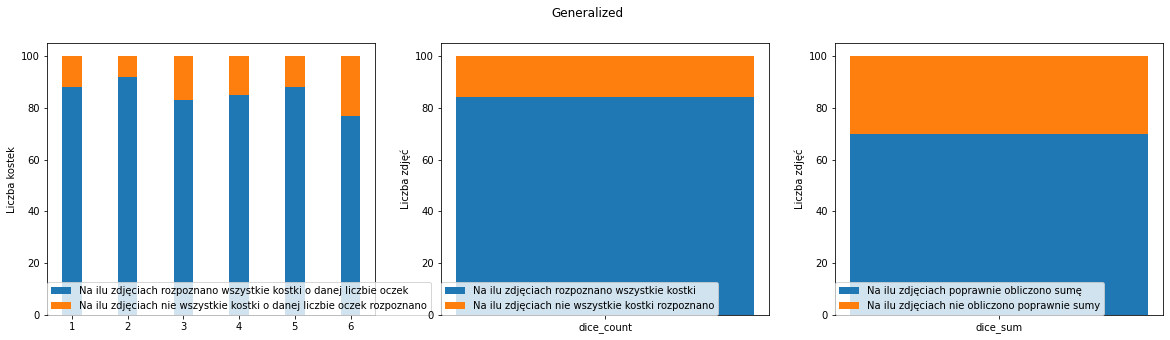

In [25]:
vals_true1 = []
vals_false1 = []
for key, value in true_count.items():
    if key != 'dice_count' and key != 'dice_sum':
        vals_true1.append(value)
        
for key, value in false_count.items():
    if key != 'dice_count' and key != 'dice_sum':
        vals_false1.append(value)
    
vals_true2 = [true_count['dice_count']]
vals_false2 = [false_count['dice_count']]
vals_true3 = [true_count['dice_sum']]
vals_false3 = [false_count['dice_sum']]

xticks1 = ['1', '2', '3', '4', '5', '6']
xticks2 = ['dice_count']
xticks3 = ['dice_sum']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(xticks1, vals_true1, 0.35, label='Na ilu zdjęciach rozpoznano wszystkie kostki o danej liczbie oczek')
ax1.bar(xticks1, vals_false1, 0.35, label='Na ilu zdjęciach nie wszystkie kostki o danej liczbie oczek rozpoznano', bottom=vals_true1)
ax1.legend(loc = (0.0, 0))
ax1.set_ylabel('Liczba kostek')

ax2.bar(xticks2, vals_true2, 0.35, label='Na ilu zdjęciach rozpoznano wszystkie kostki')
ax2.bar(xticks2, vals_false2, 0.35, label='Na ilu zdjęciach nie wszystkie kostki rozpoznano', bottom=vals_true2)
ax2.legend(loc = (0.0, 0))
ax2.set_ylabel('Liczba zdjęć')

ax3.bar(xticks3, vals_true3, 0.35, label='Na ilu zdjęciach poprawnie obliczono sumę')
ax3.bar(xticks3, vals_false3, 0.35, label='Na ilu zdjęciach nie obliczono poprawnie sumy', bottom=vals_true3)
ax3.legend(loc = (0.0, 0))
ax3.set_ylabel('Liczba zdjęć')

fig.suptitle('Generalized')
fig.patch.set_facecolor('xkcd:white')
plt.show()
           

## Creating detailed plot

In [26]:
true_count = {
    'dice_count': 0,
    1: 0,
    2: 0,
    3: 0, 
    4: 0, 
    5: 0, 
    6: 0,
    'dice_sum': 0
}

# Suma liczby kostek nierozpoznanych przez algorytm
false_count_1 = {
    'dice_count': 0,
    1: 0,
    2: 0,
    3: 0, 
    4: 0, 
    5: 0, 
    6: 0,
    'dice_sum': 0
}

# Suma liczby kostek rozpoznanych nadmiarowo przez algorytm
false_count_2 = {
    'dice_count': 0,
    1: 0,
    2: 0,
    3: 0, 
    4: 0, 
    5: 0, 
    6: 0,
    'dice_sum': 0
}
        
source = './100_dices.csv'
sted = './dices/results/sorted_100_dices.csv'
stats = './dices/stats/stats_100_dices.csv'
# Iterate through 100_dices.csv and sorted_100_dices.csv and save to stats_100_dices.csv
with open(source, 'r', newline='') as f1, open(sted, 'r', newline='') as f2, open(stats, 'w', newline='') as f3:
    
    # Create reader for 100_dices.csv and sorted_100_dices.csv
    reader_f1 = csv.reader(f1)
    reader_f2 = csv.reader(f2)
    # Omit header
    next(reader_f1)
    next(reader_f2)
    
    writer = csv.writer(f3)
    
    for row1, row2 in zip(reader_f1, reader_f2):
        
        row1[1:] = [int(x) for x in row1[1:]]
        row2[2:] = [int(y) for y in row2[2:]]
        row3 = [row1[0]]
        
        # When number of recognized dices in 100_dices.csv == sorted_100_dices.csv, then -> 0 = all were correctly recognized
        if row1[1] == row2[2]:
            row3.append(0)
            true_count['dice_count'] += row1[1]
            
        # When number of recognized dices in 100_dices.csv > sorted_100_dices.csv, then -> (100_dices.cv - sorted_100_dices.csv) = how many were not recognized (+)
        elif row1[1] > row2[2]:
            row3.append(row1[1] - row2[2])
            false_count_1['dice_count'] += row1[1] - row2[2]
            true_count['dice_count'] += row2[2]
            
        # When number of recognized dices in 100_dices.csv < sorted_100_dices.csv, then -> (100_dices.cv - sorted_100_dices.csv) = false positive (-)
        elif row1[1] < row2[2]:
            row3.append(row1[1] - row2[2])
            false_count_2['dice_count'] += abs(row1[1] - row2[2])
            true_count['dice_count'] += row1[1]

            
        i = 1
        for column1, column2 in zip(row1[2:-1], row2[3:-2]):
            if column1 == column2:
                row3.append(0)
                true_count[i] += column1  
                        
            elif column1 > column2:
                row3.append(column1 - column2)
                false_count_1[i] += column1 - column2
                true_count[i] += column2          
                
            elif column1 < column2:
                row3.append(column1 - column2)
                false_count_2[i] += abs(column1 - column2)
                true_count[i] += column1
            i += 1
    
            
        if row1[-1] == row2[-2]:
            row3.append(0)
            true_count['dice_sum'] += row1[-1]
            
        elif row1[-1] > row2[-2]:
            row3.append(row1[-1] - row2[-2])
            false_count_1['dice_sum'] += row1[-1] - row2[-2]
            
        elif row1[-1] < row2[-2]:
            row3.append(row1[-1] - row2[-2])
            false_count_2['dice_sum'] += abs(row1[-1] - row2[-2])
        
        writer.writerow(row3)
        #print(row1, row2, row3) 
    


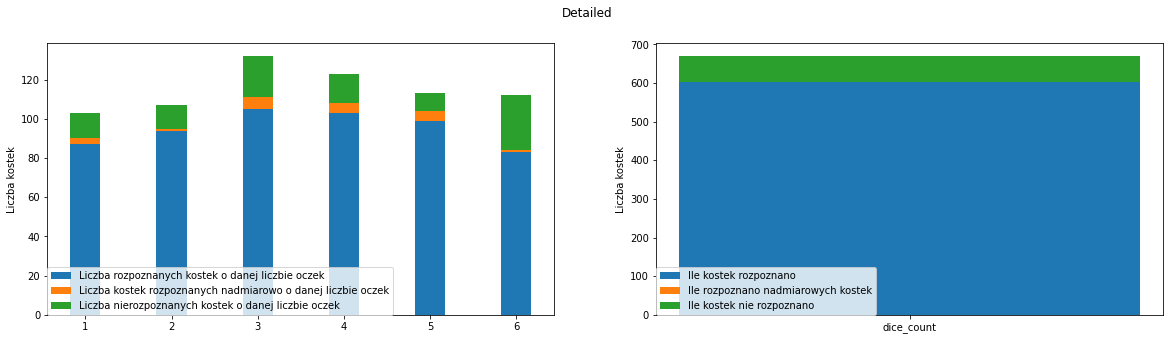

In [35]:
vals_true1 = []
vals_false_1 = []
vals_false_2 = []

for key, value in true_count.items():
    if key != 'dice_count' and key != 'dice_sum':
        vals_true1.append(value)
        
for key, value in false_count_1.items():
    if key != 'dice_count' and key != 'dice_sum':
        vals_false_1.append(value)
        
for key, value in false_count_2.items():
    if key != 'dice_count' and key != 'dice_sum':
        vals_false_2.append(value)
    
vals_true2 = [true_count['dice_count']]
vals_false_1_2 = [false_count_1['dice_count']]
vals_false_2_2 = [false_count_2['dice_count']]

xticks1 = ['1', '2', '3', '4', '5', '6']
xticks2 = ['dice_count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.bar(xticks1, vals_true1, 0.35, label='Liczba rozpoznanych kostek o danej liczbie oczek')
ax1.bar(xticks1, vals_false_2, 0.35, label='Liczba kostek rozpoznanych nadmiarowo o danej liczbie oczek', bottom=np.array(vals_true1))
ax1.bar(xticks1, vals_false_1, 0.35, label='Liczba nierozpoznanych kostek o danej liczbie oczek', bottom=np.array(vals_false_2)+np.array(vals_true1))

ax1.legend(loc = (0.0, 0))
ax1.set_ylabel('Liczba kostek')

ax2.bar(xticks2, vals_true2, 0.35, label='Ile kostek rozpoznano')
ax2.bar(xticks2, vals_false_2_2, 0.35, label='Ile rozpoznano nadmiarowych kostek', bottom=np.array(vals_true2))
ax2.bar(xticks2, vals_false_1_2, 0.35, label='Ile kostek nie rozpoznano', bottom=np.array(vals_false_2_2)+np.array(vals_true2))

ax2.legend(loc = (0.0, 0))
ax2.set_ylabel('Liczba kostek')


fig.suptitle('Detailed')
fig.patch.set_facecolor('xkcd:white')
plt.show()
